In [1]:
from FIG import FIG
import numpy as np
# Temporary PHATE / graphtools
if not hasattr(np, "float"):
    np.float = float
from PHATET import PHATET

In [2]:
from scipy import io
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load EEG data
data = io.loadmat(r'n10_8-12hz.mat')
eeg = np.transpose(data['data'])

# select all channels
Data_eeg = eeg[:,:]

# load the labels
labels_d = pd.read_excel('labelsn10.xlsx')
labels = np.array(labels_d['Unnamed: 7'])
labels  = np.reshape(labels[:860], 860)

# check the dim of the data
print(Data_eeg.shape)

time_lab = np.arange(860)

(3302400, 18)


In [3]:
from sklearn.cluster import MiniBatchKMeans
import os

In [4]:
import os
import time
import numpy as np
from sklearn.cluster import MiniBatchKMeans

GLOBAL_SEED = 172119
np.random.seed(GLOBAL_SEED)

# --------------------------------------------------
# Output directories
# --------------------------------------------------
md_dir = "/Users/chenhaozhe/Desktop/FIG/basis_rbf_MD"
time_dir = "/Users/chenhaozhe/Desktop/FIG/computation_time"

os.makedirs(md_dir, exist_ok=True)
os.makedirs(time_dir, exist_ok=True)

# --------------------------------------------------
# Data & FIG parameters
# --------------------------------------------------
X = Data_eeg
L1 = 3840
L3 = 3840
L2 = 50

# --------------------------------------------------
# 5 rows (sigma) × 4 columns (M)
# --------------------------------------------------
Ms = [10, 20, 50, 100]                    # columns (4)
sigma_scales = [0.25, 0.5, 0.75, 1.0, 1.5]  # rows (5)

# --------------------------------------------------
# Step 1: get reference sigma (sigma0)
# --------------------------------------------------
fig0 = FIG(
    X,
    window_size=L2,
    n_components=3,
    normalization="sqrt",
    lift_type="rbf",
    num_basis=50,
    center_window=L1,
    center_stride=L3,
)

fig0.fit()
sigma0 = fig0._rbf_sigma
print(f"Reference sigma0 = {sigma0:.4f}")

# --------------------------------------------------
# Storage for computation time
# Shape: (n_sigma, n_M) = (5, 4)
# rows -> sigma, columns -> M
# --------------------------------------------------
times = np.zeros((len(sigma_scales), len(Ms)))

# --------------------------------------------------
# Loop: columns first (M), rows inside (sigma)
# --------------------------------------------------
for j, M in enumerate(Ms):
    print(f"\n=== num_basis (M) = {M} ===")

    # Compute k-means centers ONCE per M
    kmeans = MiniBatchKMeans(
        n_clusters=M,
        random_state=GLOBAL_SEED,
        batch_size=1024,
    )
    kmeans.fit(X)
    centers = kmeans.cluster_centers_

    for i, scale in enumerate(sigma_scales):
        sigma = scale * sigma0
        print(f"  sigma = {scale} · sigma0 = {sigma:.4f}")

        fig = FIG(
            X,
            window_size=L2,
            n_components=3,
            lift_type="rbf",
            normalization="sqrt",
            num_basis=M,
            center_window=L1,
            center_stride=L3,
            rbf_centers=centers,
            rbf_sigma=sigma,
            random_state=GLOBAL_SEED,
        )

        start_time = time.perf_counter()
        MD = fig.fit()
        elapsed = time.perf_counter() - start_time

        times[i, j] = elapsed   # 👈 row = sigma, col = M

        fname = f"MD_rbf_M{M}_sigma{scale:.2f}sigma0.npy"
        np.save(os.path.join(md_dir, fname), MD)

        print(f"    saved -> {fname} | time = {elapsed:.2f}s")

# --------------------------------------------------
# Save timing + metadata
# --------------------------------------------------
np.save(os.path.join(time_dir, "rbf_times.npy"), times)

np.save(
    os.path.join(time_dir, "rbf_grid_meta.npy"),
    {
        "Ms": Ms,
        "sigma_scales": sigma_scales,
        "sigma0": sigma0,
        "grid_shape": "(sigma rows, M columns)",
        "window_size": L2,
        "center_window": L1,
        "center_stride": L3,
        "seed": GLOBAL_SEED,
    },
)

print("\nRBF computation time saved to:", time_dir)
print("Timing matrix shape:", times.shape)


Reference sigma0 = 12.6603

=== num_basis (M) = 10 ===


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  sigma = 0.25 · sigma0 = 3.1651
    saved -> MD_rbf_M10_sigma0.25sigma0.npy | time = 4.23s
  sigma = 0.5 · sigma0 = 6.3301
    saved -> MD_rbf_M10_sigma0.50sigma0.npy | time = 4.24s
  sigma = 0.75 · sigma0 = 9.4952
    saved -> MD_rbf_M10_sigma0.75sigma0.npy | time = 4.30s
  sigma = 1.0 · sigma0 = 12.6603
    saved -> MD_rbf_M10_sigma1.00sigma0.npy | time = 4.25s
  sigma = 1.5 · sigma0 = 18.9904
    saved -> MD_rbf_M10_sigma1.50sigma0.npy | time = 4.73s

=== num_basis (M) = 20 ===


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  sigma = 0.25 · sigma0 = 3.1651
    saved -> MD_rbf_M20_sigma0.25sigma0.npy | time = 5.30s
  sigma = 0.5 · sigma0 = 6.3301
    saved -> MD_rbf_M20_sigma0.50sigma0.npy | time = 4.77s
  sigma = 0.75 · sigma0 = 9.4952
    saved -> MD_rbf_M20_sigma0.75sigma0.npy | time = 4.55s
  sigma = 1.0 · sigma0 = 12.6603
    saved -> MD_rbf_M20_sigma1.00sigma0.npy | time = 4.53s
  sigma = 1.5 · sigma0 = 18.9904
    saved -> MD_rbf_M20_sigma1.50sigma0.npy | time = 4.64s

=== num_basis (M) = 50 ===


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  sigma = 0.25 · sigma0 = 3.1651
    saved -> MD_rbf_M50_sigma0.25sigma0.npy | time = 6.03s
  sigma = 0.5 · sigma0 = 6.3301
    saved -> MD_rbf_M50_sigma0.50sigma0.npy | time = 6.16s
  sigma = 0.75 · sigma0 = 9.4952
    saved -> MD_rbf_M50_sigma0.75sigma0.npy | time = 5.88s
  sigma = 1.0 · sigma0 = 12.6603
    saved -> MD_rbf_M50_sigma1.00sigma0.npy | time = 5.72s
  sigma = 1.5 · sigma0 = 18.9904
    saved -> MD_rbf_M50_sigma1.50sigma0.npy | time = 5.75s

=== num_basis (M) = 100 ===


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


  sigma = 0.25 · sigma0 = 3.1651
    saved -> MD_rbf_M100_sigma0.25sigma0.npy | time = 8.96s
  sigma = 0.5 · sigma0 = 6.3301
    saved -> MD_rbf_M100_sigma0.50sigma0.npy | time = 7.99s
  sigma = 0.75 · sigma0 = 9.4952
    saved -> MD_rbf_M100_sigma0.75sigma0.npy | time = 8.74s
  sigma = 1.0 · sigma0 = 12.6603
    saved -> MD_rbf_M100_sigma1.00sigma0.npy | time = 9.09s
  sigma = 1.5 · sigma0 = 18.9904
    saved -> MD_rbf_M100_sigma1.50sigma0.npy | time = 8.11s

RBF computation time saved to: /Users/chenhaozhe/Desktop/FIG/computation_time
Timing matrix shape: (5, 4)


In [5]:
import os

# --------------------------------------------------
# Directory with RBF MD matrices
# --------------------------------------------------
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_rbf_MD"

# --------------------------------------------------
# Collect all MD files
# --------------------------------------------------
md_files = sorted([
    f for f in os.listdir(base_dir)
    if f.startswith("MD_") and f.endswith(".npy")
])

print(f"Found {len(md_files)} MD files")

# --------------------------------------------------
# Loop over all MD matrices
# --------------------------------------------------
for fname in md_files:
    print(f"\nProcessing {fname}")

    path = os.path.join(base_dir, fname)
    MD = np.load(path)

    # --------------------------------------------------
    # PHATE → 10D (precomputed distance)
    # --------------------------------------------------
    phate_10d = PHATET(
        knn_dist="precomputed_distance",
        k=20,
        n_components=10,
        verbose=0,
    )

    Z_10d = phate_10d.fit_transform(MD)

    # --------------------------------------------------
    # PHATE → 2D (on 10D embedding)
    # --------------------------------------------------
    phate_2d = PHATET(
        n_components=2,
        k=20,
        verbose=0,
    )

    fig_2d = phate_2d.fit_transform(Z_10d)

    # --------------------------------------------------
    # PHATE → 3D (on 10D embedding)
    # --------------------------------------------------
    phate_3d = PHATET(
        n_components=3,
        k=20,
        verbose=0,
    )

    fig_3d = phate_3d.fit_transform(Z_10d)

    # --------------------------------------------------
    # Save embeddings
    # --------------------------------------------------
    base = fname.replace(".npy", "")

    out_2d = os.path.join(base_dir, f"fig_2d_{base}.npy")
    out_3d = os.path.join(base_dir, f"fig_3d_{base}.npy")

    np.save(out_2d, fig_2d)
    np.save(out_3d, fig_3d)

    print(f"  saved -> {out_2d}")
    print(f"  saved -> {out_3d}")


Found 20 MD files

Processing MD_rbf_M100_sigma0.25sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 467 with stress 0.5806545311845116


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 52 with stress 19515.02874848992


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 333 with stress 8457.690563187834
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M100_sigma0.25sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M100_sigma0.25sigma0.npy

Processing MD_rbf_M100_sigma0.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 570 with stress 0.3590422950095006


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 17 with stress 23074.33972233463


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 229 with stress 9688.687689766852
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M100_sigma0.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M100_sigma0.50sigma0.npy

Processing MD_rbf_M100_sigma0.75sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 512 with stress 1.1133489104214211


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 111 with stress 20210.733733604233


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 602 with stress 8649.873095769006
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M100_sigma0.75sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M100_sigma0.75sigma0.npy

Processing MD_rbf_M100_sigma1.00sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 464 with stress 5.200150854514895


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 64 with stress 19023.996430940024


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 805 with stress 7871.8740108767815
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M100_sigma1.00sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M100_sigma1.00sigma0.npy

Processing MD_rbf_M100_sigma1.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1686 with stress 3.1623855712433304


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 925 with stress 17523.717318011364


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 255 with stress 6878.1995382824325
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M100_sigma1.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M100_sigma1.50sigma0.npy

Processing MD_rbf_M10_sigma0.25sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 784 with stress 7.67978680621047


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 174 with stress 20102.598029708854


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 595 with stress 8452.922857489964
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M10_sigma0.25sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M10_sigma0.25sigma0.npy

Processing MD_rbf_M10_sigma0.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1030 with stress 4.024115647130559


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 165 with stress 20703.04720827257


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 615 with stress 8372.076764649233
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M10_sigma0.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M10_sigma0.50sigma0.npy

Processing MD_rbf_M10_sigma0.75sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1275 with stress 2.5503730287033677


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 802 with stress 19155.322002852783


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 668 with stress 7626.729843853646
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M10_sigma0.75sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M10_sigma0.75sigma0.npy

Processing MD_rbf_M10_sigma1.00sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1506 with stress 3.28107432629788


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 107 with stress 15476.947220958602


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 682 with stress 5906.245413979164
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M10_sigma1.00sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M10_sigma1.00sigma0.npy

Processing MD_rbf_M10_sigma1.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1576 with stress 11.279215502307336


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 103 with stress 14094.389866840585


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 313 with stress 5527.892445118657
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M10_sigma1.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M10_sigma1.50sigma0.npy

Processing MD_rbf_M20_sigma0.25sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1368 with stress 3.2021181165020733


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 31 with stress 21036.731814896466


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 234 with stress 6873.7832296173765
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M20_sigma0.25sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M20_sigma0.25sigma0.npy

Processing MD_rbf_M20_sigma0.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 695 with stress 2.4673741135166036


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 151 with stress 19041.815495507213


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 378 with stress 7804.594875867042
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M20_sigma0.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M20_sigma0.50sigma0.npy

Processing MD_rbf_M20_sigma0.75sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 646 with stress 7.09675438078083


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 86 with stress 17963.637137002846


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 841 with stress 6952.381877136076
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M20_sigma0.75sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M20_sigma0.75sigma0.npy

Processing MD_rbf_M20_sigma1.00sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1766 with stress 3.044284104922644


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 167 with stress 15542.760425165055


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 302 with stress 6086.872634202772
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M20_sigma1.00sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M20_sigma1.00sigma0.npy

Processing MD_rbf_M20_sigma1.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1865 with stress 6.550647382643989


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 126 with stress 14092.661335810448


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 194 with stress 5641.350458695569
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M20_sigma1.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M20_sigma1.50sigma0.npy

Processing MD_rbf_M50_sigma0.25sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 537 with stress 0.37814999886384965


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 58 with stress 18639.624188121805


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 637 with stress 8240.983767924163
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M50_sigma0.25sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M50_sigma0.25sigma0.npy

Processing MD_rbf_M50_sigma0.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 427 with stress 0.39672325400729125


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 39 with stress 20098.257029925913


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 453 with stress 8870.711116770848
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M50_sigma0.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M50_sigma0.50sigma0.npy

Processing MD_rbf_M50_sigma0.75sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 457 with stress 2.025663666663088


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 74 with stress 19076.970886431558


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 487 with stress 8160.625317618368
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M50_sigma0.75sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M50_sigma0.75sigma0.npy

Processing MD_rbf_M50_sigma1.00sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 493 with stress 3.2942438507066703


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 130 with stress 20082.16392024908


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 579 with stress 8231.174959893735
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M50_sigma1.00sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M50_sigma1.00sigma0.npy

Processing MD_rbf_M50_sigma1.50sigma0.npy


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 1749 with stress 3.320454944605099


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 53 with stress 14973.193912494418


/Users/chenhaozhe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


breaking at iteration 289 with stress 5793.3229851943515
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_2d_MD_rbf_M50_sigma1.50sigma0.npy
  saved -> /Users/chenhaozhe/Desktop/FIG/basis_rbf_MD/fig_3d_MD_rbf_M50_sigma1.50sigma0.npy


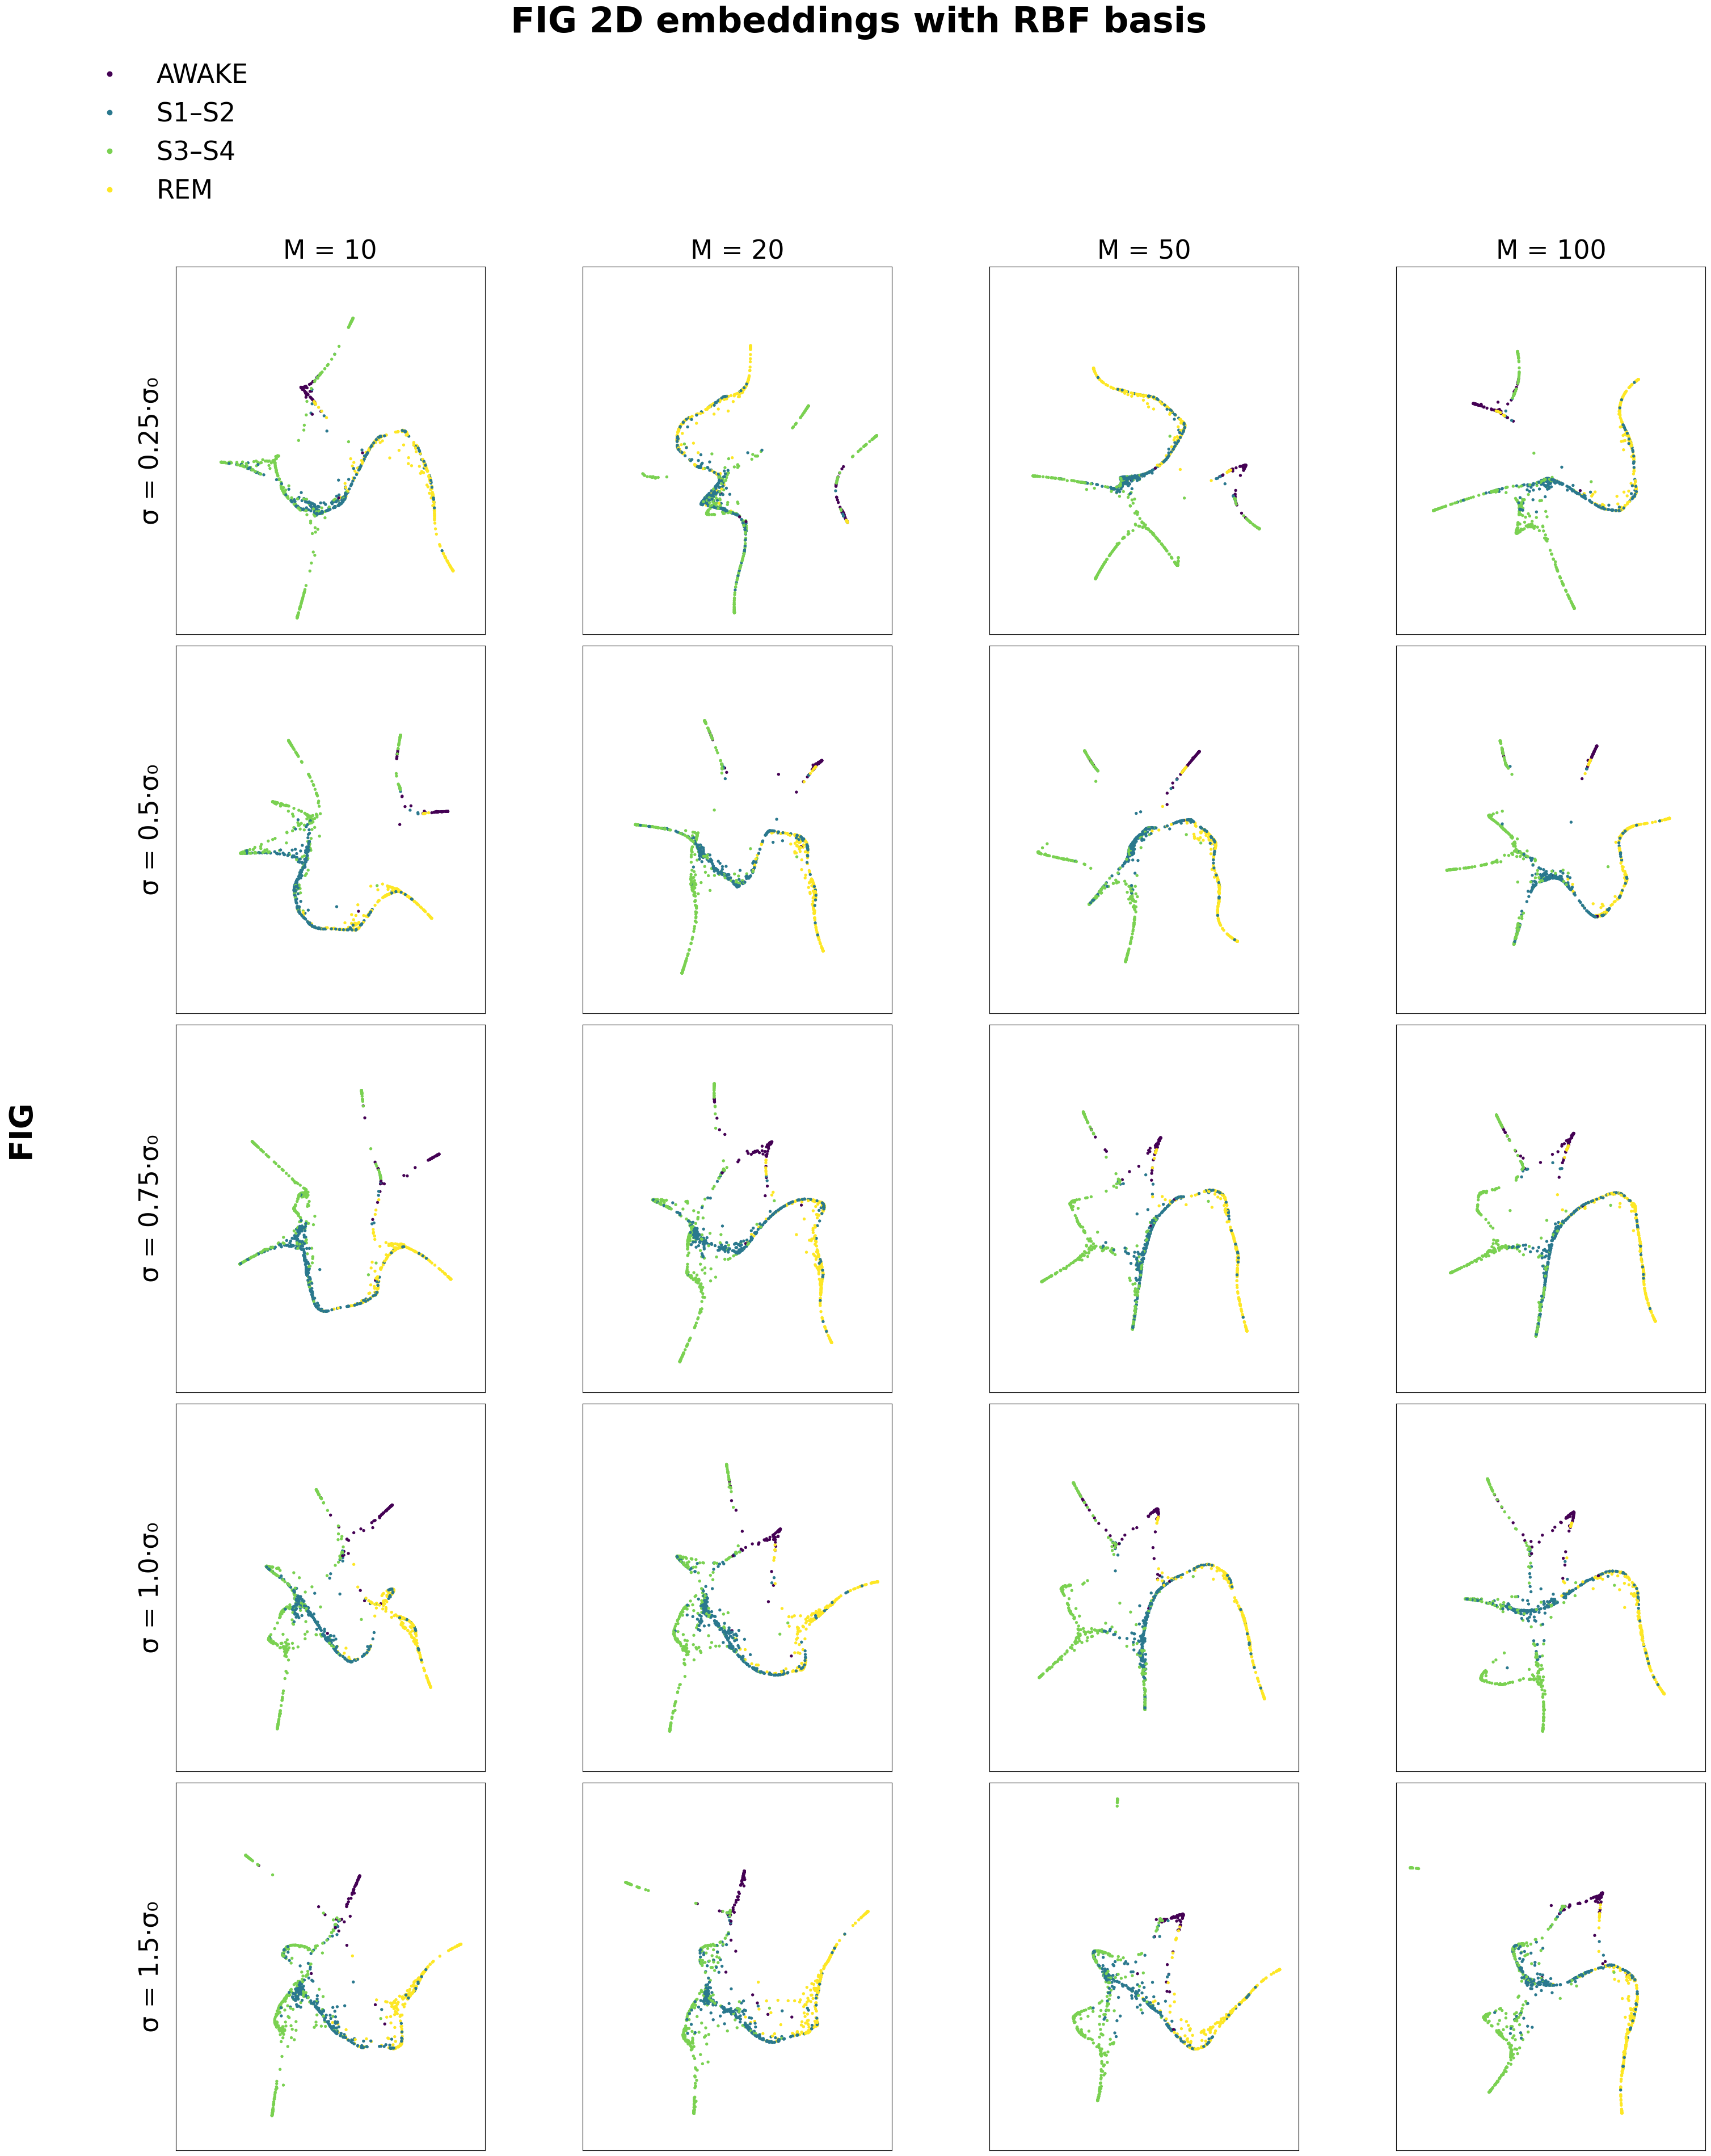

In [6]:
from matplotlib import pyplot as plt


# ==================================================
# Step 0: merge labels (ONCE)
# ==================================================
labels_merged = labels.copy()
labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1–S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3–S4

# ==================================================
# Directory
# ==================================================
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_rbf_MD"

# ==================================================
# Grid definition (5 rows × 4 columns)
# ==================================================
Ms = [10, 20, 50, 100]                    # columns
sigma_scales = [0.25, 0.5, 0.75, 1.0, 1.5]  # rows

# ==================================================
# Legend dictionary (merged labels)
# ==================================================
legend_dict = {
    0: "AWAKE",
    2: "S1–S2",
    4: "S3–S4",
    5: "REM",
}

# ==================================================
# Dummy scatter (for legend handles only)
# ==================================================
dummy_path = os.path.join(
    base_dir, f"fig_2d_MD_rbf_M{Ms[0]}_sigma{sigma_scales[0]:.2f}sigma0.npy"
)

dummy_fig = np.load(dummy_path)

scatterplot = plt.scatter(
    dummy_fig[:, 0],
    dummy_fig[:, 1],
    c=labels_merged,
    s=8,
)
plt.close()

# ==================================================
# Create figure
# ==================================================
fig, axes = plt.subplots(
    nrows=len(sigma_scales),
    ncols=len(Ms),
    figsize=(32, 40),
    sharex=True,
    sharey=True,
)

# ==================================================
# Plot loop
# ==================================================
for i, sigma in enumerate(sigma_scales):
    for j, M in enumerate(Ms):
        ax = axes[i, j]

        fname = f"fig_2d_MD_rbf_M{M}_sigma{sigma:.2f}sigma0.npy"
        Z = np.load(os.path.join(base_dir, fname))

        ax.scatter(
            Z[:, 0],
            Z[:, 1],
            c=labels_merged,
            s=8,
        )

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal", adjustable="box")

        # Column titles (top row)
        if i == 0:
            ax.set_title(
                f"M = {M}",
                fontsize=33,
                pad=10,
            )

        # Row labels (left column)
        if j == 0:
            ax.set_ylabel(
                f"σ = {sigma}·σ₀",
                fontsize=33,
                rotation=90,
                labelpad=15,
            )

# ==================================================
# Global FIG label
# ==================================================
fig.text(
    0.03,
    0.5,
    "FIG",
    va="center",
    rotation="vertical",
    fontsize=40,
    fontweight="bold",
)

# ==================================================
# Global legend
# ==================================================
legend_labels = [legend_dict[label] for label in np.unique(labels_merged)]

fig.legend(
    handles=scatterplot.legend_elements()[0],
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(0.06, 0.98),
    fontsize=33,
    frameon=False,
)

# ==================================================
# Global title
# ==================================================
fig.suptitle(
    "FIG 2D embeddings with RBF basis",
    fontsize=45,
    y=0.995,
    fontweight="bold",
)

# ==================================================
# Layout tuning (tight rows)
# ==================================================
plt.subplots_adjust(
    left=0.1,
    right=0.99,
    top=0.88,
    bottom=0.05,
    wspace=0.03,
    hspace=0.03,
)

plt.show()


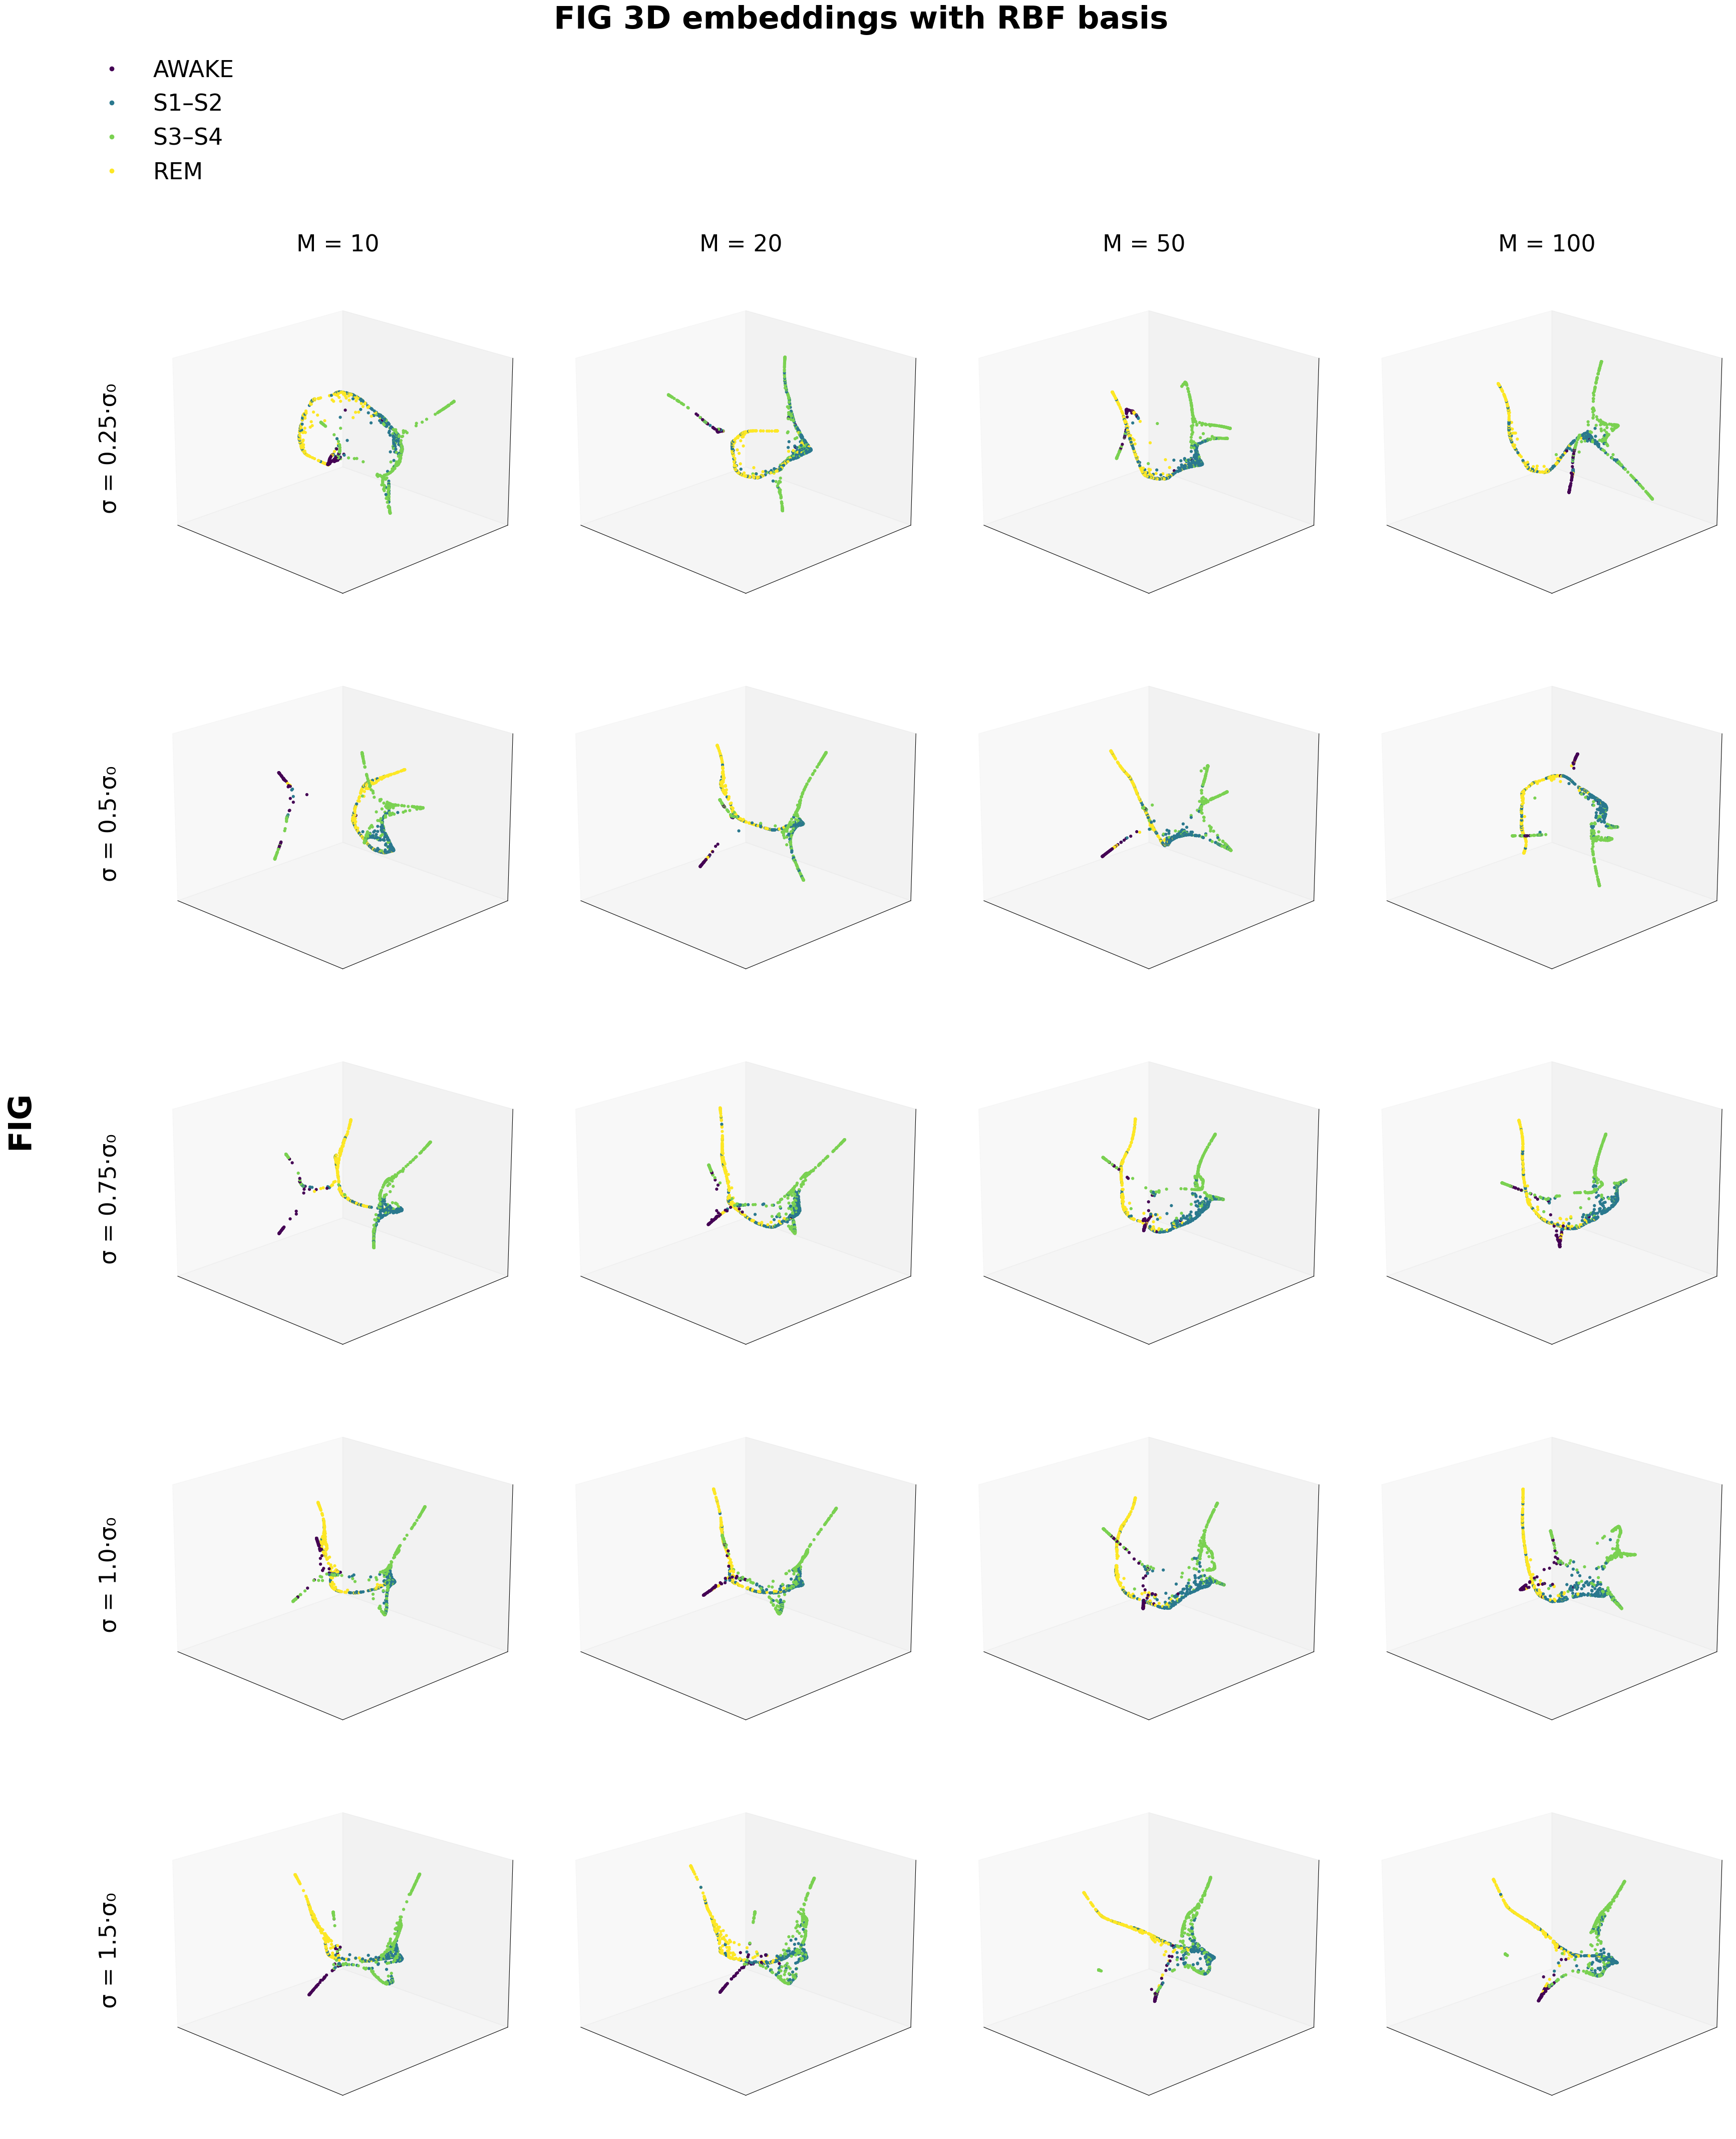

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ==================================================
# Step 0: merge labels (ONCE)
# ==================================================
labels_merged = labels.copy()
labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1–S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3–S4

# ==================================================
# Directory
# ==================================================
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_rbf_MD"

# ==================================================
# Grid definition (5 rows × 4 columns)
# ==================================================
Ms = [10, 20, 50, 100]                    # columns
sigma_scales = [0.25, 0.5, 0.75, 1.0, 1.5]  # rows

# ==================================================
# Legend dictionary
# ==================================================
legend_dict = {
    0: "AWAKE",
    2: "S1–S2",
    4: "S3–S4",
    5: "REM",
}

# ==================================================
# STEP 1: compute global 3D axis limits
# ==================================================
all_points = []

for sigma in sigma_scales:
    for M in Ms:
        fname = f"fig_3d_MD_rbf_M{M}_sigma{sigma:.2f}sigma0.npy"
        Z = np.load(os.path.join(base_dir, fname))
        all_points.append(Z)

all_points = np.vstack(all_points)

x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
z_min, z_max = all_points[:, 2].min(), all_points[:, 2].max()

# Padding
pad_x = 0.05 * (x_max - x_min)
pad_y = 0.05 * (y_max - y_min)
pad_z = 0.05 * (z_max - z_min)

xlim = (x_min - pad_x, x_max + pad_x)
ylim = (y_min - pad_y, y_max + pad_y)
zlim = (z_min - pad_z, z_max + pad_z)

# ==================================================
# Dummy scatter (legend handles only)
# ==================================================
dummy_fig = all_points[:len(labels_merged)]

scatterplot = plt.scatter(
    dummy_fig[:, 0],
    dummy_fig[:, 1],
    c=labels_merged,
    s=12,
)
plt.close()

# ==================================================
# Create figure (3D subplots)
# ==================================================
fig = plt.figure(figsize=(36, 45))
axes = np.empty((len(sigma_scales), len(Ms)), dtype=object)

for i in range(len(sigma_scales)):
    for j in range(len(Ms)):
        axes[i, j] = fig.add_subplot(
            len(sigma_scales),
            len(Ms),
            i * len(Ms) + j + 1,
            projection="3d",
        )

# ==================================================
# Plot loop
# ==================================================
for i, sigma in enumerate(sigma_scales):
    for j, M in enumerate(Ms):
        ax = axes[i, j]

        fname = f"fig_3d_MD_rbf_M{M}_sigma{sigma:.2f}sigma0.npy"
        Z = np.load(os.path.join(base_dir, fname))

        ax.scatter(
            Z[:, 0],
            Z[:, 1],
            Z[:, 2],
            c=labels_merged,
            s=12,
            depthshade=False,
        )

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # Consistent viewing angle
        ax.view_init(elev=20, azim=135)

        # Column titles (top row)
        if i == 0:
            ax.set_title(
                f"M = {M}",
                fontsize=33,
                pad=18,
            )

        # Row labels (left column)
        if j == 0:
            ax.text2D(
                -0.15,
                0.5,
                f"σ = {sigma}·σ₀",
                transform=ax.transAxes,
                fontsize=33,
                rotation=90,
                va="center",
            )

# ==================================================
# Global FIG label
# ==================================================
fig.text(
    0.025,
    0.5,
    "FIG",
    va="center",
    rotation="vertical",
    fontsize=45,
    fontweight="bold",
)

# ==================================================
# Global legend
# ==================================================
legend_labels = [legend_dict[label] for label in np.unique(labels_merged)]

fig.legend(
    handles=scatterplot.legend_elements()[0],
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(0.06, 0.98),
    fontsize=33,
    frameon=False,
)

# ==================================================
# Global title
# ==================================================
fig.suptitle(
    "FIG 3D embeddings with RBF basis",
    fontsize=45,
    y=0.995,
    fontweight="bold",
)

# ==================================================
# Layout tuning
# ==================================================
plt.subplots_adjust(
    left=0.1,
    right=0.99,
    top=0.88,
    bottom=0.05,
    wspace=0.02,
    hspace=0.02,
)

plt.show()
